### Setup

Import Caffe and the usual modules.

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import PCA

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import _init_paths
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.bbox_transform import clip_boxes, bbox_transform_inv
from fast_rcnn.test import _get_blobs
import caffe, os, sys, cv2

### Configure all the constants

Define net path, data path and so on.

In [17]:
#DATA_PATH = '/mnt/wb/dataset/LINEMOD_LARGE4FRCNN'
DATA_PATH = '/mnt/wb/dataset/LINEMOD_APE_PARAM/BG_PARAM_C'
FASTER_RCNN_ROOT = '/mnt/wb/project/py-faster-rcnn'

CLASSES = ('__background__',
           'ape', 'benchviseblue', 'bowl', 'cam', 'can', 
           'cat', 'cup', 'driller', 'duck', 'eggbox', 
           'glue', 'holepuncher', 'iron', 'lamp', 'phone')

NETS = {'pose_zf_400k': ('ZF/faster_rcnn_end2end',
                  'linemod_pose_test.prototxt',
                  'linemod_pose_zf_iter_400000.caffemodel'),
        'sub_pose_zf_1000k': ('ZF/faster_rcnn_end2end',
                  'linemod_sub_pose_test.prototxt',
                  'linemod_sub_pose_zf_iter_1000000.caffemodel'),
        'ape_pose_zf_1000k': ('ZF/faster_rcnn_end2end',
                  'linemod_ape_pose_test.prototxt',
                  'linemod_ape_pose_zf_iter_1000000.caffemodel'),
        'apec2_pose_zf_200k': ('ZF/faster_rcnn_end2end',
                  'linemod_apeb_pose_test.prototxt',
                  'linemod_apec_pose_zf_2_iter_200000.caffemodel'),
        'apec_pose_zf_200k': ('ZF/faster_rcnn_end2end',
                  'linemod_apeb_pose_test.prototxt',
                  'linemod_apec_pose_zf_iter_200000.caffemodel')}

TO_BE_CLASS = CLASSES[1]
DATASETS = {'linemod_test': 
                (DATA_PATH + '/data/ImageSets/test.txt',
                 DATA_PATH + '/data/Images')}
images = DATASETS['linemod_test'][0]

CFG_FILE = FASTER_RCNN_ROOT+'/experiments/wb_cfgs/linemod_largeapec_pose_end2end.yml'

GPU_ID = 5
cfg.GPU_ID = GPU_ID

prototxt = os.path.join(cfg.ROOT_DIR, 'models', NETS['apec2_pose_zf_200k'][0],
                            NETS['apec2_pose_zf_200k'][1])
caffemodel = os.path.join(cfg.ROOT_DIR, 'output', 'linemod_end2end',
                              NETS['apec2_pose_zf_200k'][2])

### Load net

In [18]:
cfg_from_file(CFG_FILE)

caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

### Load data

Load image

In [19]:
image_names = [line.strip() for line in open(images).readlines()]
image_pathes = ['{0}/{1}{2}'.format( DATASETS['linemod_test'][1], image_name, '.jpg')\
                for image_name in image_names]

curr_img_id = 12
im = cv2.imread(image_pathes[curr_img_id])

### Compute features
Compute features of selected layers

In [20]:
blobs, im_scales = _get_blobs(im, None)
im_blob = blobs['data']
blobs['im_info'] = np.array([[im_blob.shape[2], im_blob.shape[3], im_scales[0]]],
                            dtype=np.float32)

# reshape network inputs
net.blobs['data'].reshape(*(blobs['data'].shape))
net.blobs['im_info'].reshape(*(blobs['im_info'].shape))
# do forward
forward_kwargs = {'data': blobs['data'].astype(np.float32, copy=False)}
forward_kwargs['im_info'] = blobs['im_info'].astype(np.float32, copy=False)

feat_blobs_names = ['rois']
blobs_out = net.forward(blobs=feat_blobs_names, **forward_kwargs)

assert len(im_scales) == 1, "Only single-image batch implemented"
rois = blobs_out['rois'].copy()
# unscale back to raw image space
boxes = rois[:, 1:5] / im_scales[0]

### Draw ROIs

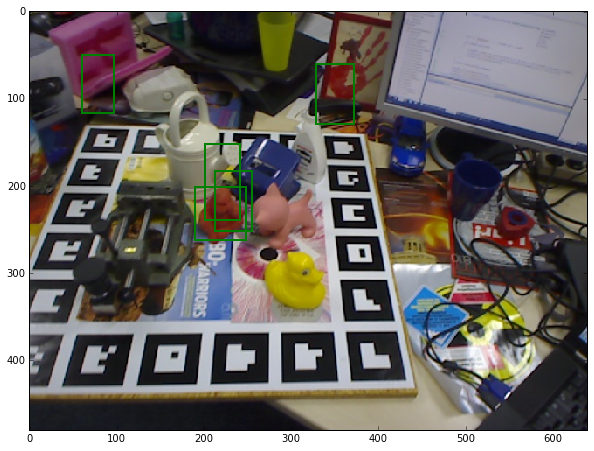

In [27]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(im[:, :, (2, 1, 0)])
boxes_num = boxes.shape[0]
for i in range(5):
    bbox = boxes[i] 
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                        bbox[2] - bbox[0],
                        bbox[3] - bbox[1], fill=False,
                        edgecolor='g', linewidth=2)
                        )
plt.show()